(389, 389)
(778, 1) (1, 778) (778, 778)


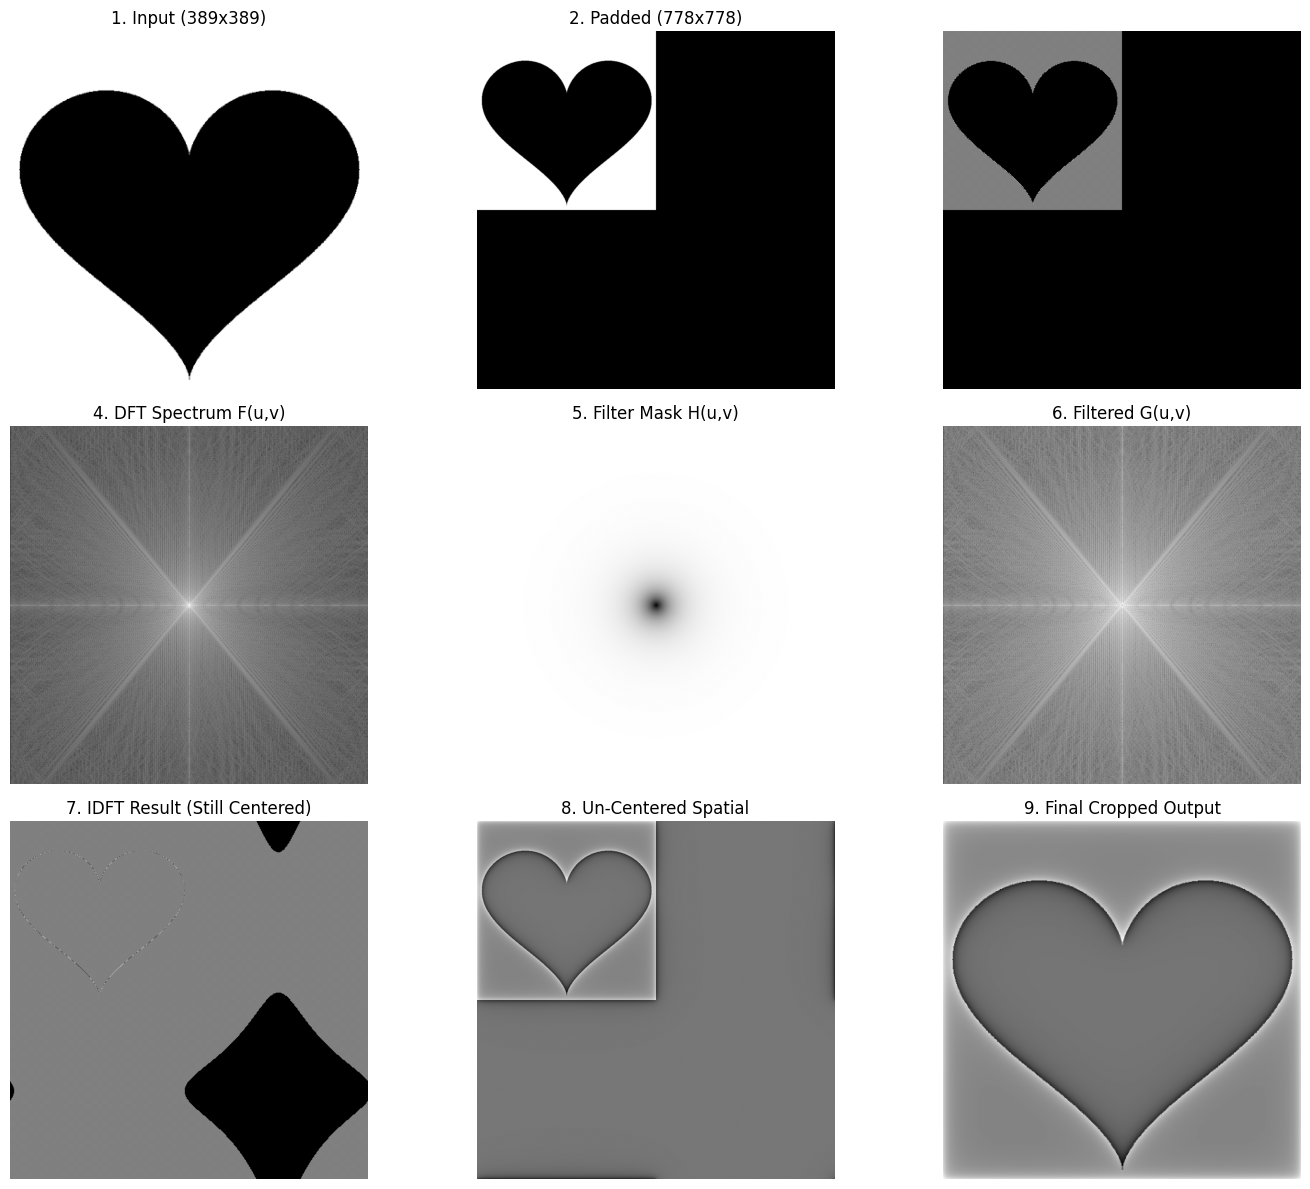

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 0. Load the image
img = Image.open("heart.png").convert('L')
f = np.array(img, dtype=float)
M, N = f.shape

print(f.shape)

# --- PARAMETERS TO PLAY WITH ---
cutoff_radius = 100   
# ------------------

# --- STEP 1: PADDING ---
# We pad to P x Q (double size) to avoid circular convolution wraparound
P, Q = 2 * M, 2 * N
f_padded = np.pad(f, ((0, M), (0, N)), 'constant', constant_values=0)

# --- STEP 2: CENTERING (The (-1)^(x+y) Step) ---
# We create a matrix of the same size P x Q where every pixel is 1 or -1
x = np.arange(P).reshape(-1, 1)  # Column vector of rows indices
y = np.arange(Q).reshape(1, -1)  # Row vector of col indices
centering_matrix = (-1) ** (x + y)

print(x.shape, y.shape, centering_matrix.shape)

# Apply the checkerboard pattern
f_centered = f_padded * centering_matrix

# --- STEP 3: DFT ---
F = np.fft.fft2(f_centered)

# --- STEP 4: FILTER CONSTRUCTION ---
# Create the Distance Grid D(u,v) from the center (P/2, Q/2)
u = np.arange(P).reshape(-1, 1)
v = np.arange(Q).reshape(1, -1)
D_uv = np.sqrt((u - P/2)**2 + (v - Q/2)**2)

# Create Ideal Low Pass Filter H
H = np.zeros((P, Q))
n=2
H = 1/(1+(D_uv/cutoff_radius))**(2*n)
H=1-H

#equation/filter type to be changed and 
#IDEAL LOWPASS: <=cutoff_radius
#GUASSIAN LOWPASS: np.exp(-1*D_uv**2/(2*cutoff_radius**2))
#BUTTERWORTH LOW PASS SMOOTHING FILTER: 1/(1+(D_uv/cutoff_radius))**(2*n)
#

# --- STEP 5: FILTERING ---
# Element-wise multiplication
G = H * F

# --- STEP 6: IDFT ---
# Compute Inverse DFT. 
# The result is complex, we take the Real part.
g_centered_complex = np.fft.ifft2(G)
g_centered_real = np.real(g_centered_complex)

# --- UN-CENTERING ---
# The result is still multiplied by (-1)^(x+y), so we multiply again to reverse it.
g_padded = g_centered_real * centering_matrix

# --- STEP 7: CROP ---
# Extract the top-left M x N region
g_final = g_padded[0:M, 0:N]


# --- VISUALIZATION OF EVERY STEP ---
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3)

# Row 1: Spatial Pre-processing
axes[0,0].imshow(f, cmap='gray'); axes[0,0].set_title(f"1. Input ({M}x{N})")
axes[0,1].imshow(f_padded, cmap='gray'); axes[0,1].set_title(f"2. Padded ({P}x{Q})")
axes[0,2].imshow(Image.fromarray(np.uint8(f_centered)), cmap='gray', vmin=0, vmax=255)

# Row 2: Frequency Domain
# We show log(magnitude) for visibility
#axes[1,0].imshow(np.abs(F), cmap='gray'); axes[1,0].set_title("4. DFT Spectrum F(u,v)")
axes[1,0].imshow(np.log(1 + np.abs(F)), cmap='gray'); axes[1,0].set_title("4. DFT Spectrum F(u,v)")
axes[1,1].imshow(H, cmap='gray'); axes[1,1].set_title("5. Filter Mask H(u,v)")
axes[1,2].imshow(np.log(1 + np.abs(G)), cmap='gray'); axes[1,2].set_title("6. Filtered G(u,v)")

# Row 3: Spatial Post-processing
axes[2,0].imshow(Image.fromarray(np.uint8(g_centered_real)), cmap='gray'); axes[2,0].set_title("7. IDFT Result (Still Centered)")
axes[2,1].imshow(g_padded, cmap='gray'); axes[2,1].set_title("8. Un-Centered Spatial")
axes[2,2].imshow(g_final, cmap='gray'); axes[2,2].set_title("9. Final Cropped Output")

for ax in axes.flatten(): ax.axis('off')
plt.tight_layout()
plt.show()

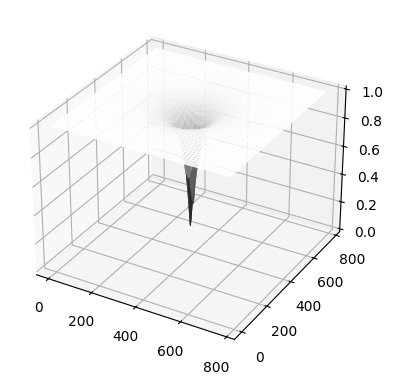

In [20]:
fig = plt.figure(figsize=(10, 5))
 
awq = fig.add_subplot(1, 2, 1, projection='3d')
awq.plot_surface(x, y, H  , cmap='gray')
 
plt.show()